# trying out some benchmarking techniques
Copyright Jim Smith,

a lot of initial inspiration for code structure taken from https://machinelearningmastery.com/how-to-develop-deep-learning-models-for-univariate-time-series-forecasting/

but also borrowing some ideas from here: https://towardsdatascience.com/get-started-with-using-cnn-lstm-for-forecasting-6f0f4dde5826

Update 10-09-20:
Major rewrite  to class-based version for models to tidy things up and so that I can run tests in batch mode


In [1]:
#%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# load and plot dataset
from math import sqrt

import numpy as np

from pandas import DataFrame, Series
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [9.5, 6]

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D




Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

# Common functions

In [2]:

def load_data():
    global scaler
    # load
    series = read_csv('pm2.5.csv', header=0)
    # summarize shape
    print(series.shape)
    n_test = int(series.shape[0]*0.1)
    print ( 'setting n_test = {}'.format(n_test))
    data = series.values
    if(useLogTransform==True):
        data = np.log(data)
    if (useStandardisation==True):
        data = scaler.fit_transform(data)
    
    return data, n_test


# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]
 
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1,  lookAhead=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(( lookAhead -1), (lookAhead-1) + n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    global scaler
    if (useStandardisation==True):
        myactual = scaler.inverse_transform(actual)
        mypredicted = scaler.inverse_transform(predicted)
    else:
        myactual = actual
        mypredicted = predicted
    if(useLogTransform==True):
        myactual = np.exp(myactual)
        mypredicted = np.exp(mypredicted)
    return np.sqrt(mean_squared_error(myactual, mypredicted))

def measure_mape(actual,predicted):
    #if(1==1):
    #    return 0
    
    minVal = 0.0001
    global scaler
    if (useStandardisation==True):
        myactual = scaler.inverse_transform(actual)
        mypredicted = scaler.inverse_transform(predicted)
    else:
        myactual = actual
        mypredicted = predicted
    if(useLogTransform==True):
        myactual = np.exp(myactual)
        mypredicted = np.exp(mypredicted)
    
    return np.mean(np.abs((myactual - mypredicted) / (myactual+minVal))) * 100
 
# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]




# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, model):
    global run
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model.fit(train,n_epochs=maxEpochs,batchsize=batchsize)
    
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model.predict(history)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    mape = measure_mape(test,predictions)
    print(' run {}, RMSE {},  MAPE {}'.format(run,error,mape))

    #save predictions to file
    outname = 'predictions/' +str(model.lookAhead)+'hr-'+ model.name  +datapartname + '-run' + str(run) +'.csv'
    np.savetxt(outname,predictions,delimiter=',')
    run = run+1
    return error, mape

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = np.mean(scores), np.std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    plt.boxplot(scores)
    plt.show()
    
    
    # repeat evaluation of a config
def repeat_evaluate(data, model, n_test, n_repeats=1):
    # fit and evaluate the model n times
    global run
    run = 0
    scores = [walk_forward_validation(data, n_test, model) for _ in range(n_repeats)]
    return scores
 


# Persistence
We will use the config to define a list of index offsets in the prior observations relative to the time to be forecasted that will be used as the prediction. For example, 12 will use the observation 12 months ago (-12) relative to the time to be forecasted.

Jim's version:  predicting the value for time t calculate the median of a set of values. 
Two berhaviours are possible:
- if intermediates==False the set is jsut the extrema $\{ t - lookAhead, t-windowlength\}$
- if intermediate it is the set $\{t-lookAhead, t-lookAhead -step, t-lookahead-2*step, \ldots,t-windowlength\}$


In [3]:

# persistence

class persistent_Model():
    # fit a model
    
    def __init__(self,lookAhead=1,windowlength=1, intermediates=False, step=1,n_out=1):
        self.name = 'persistent'
        self.lookAhead = lookAhead
        self.windowlength = windowlength
        self.intermediates = intermediates
        self.step=step
        self.n_out=n_out

        
    def fit(self,train,n_epochs=1,batchsize=1):
        return None
 
    # forecast with a pre-fit model
    def predict(self,history):
        values = list()
        if (self.intermediates == True):
            for offset in (1, self.windowLength +1, self.step):
                values.append(history[-offset])
        else:
            for offset in (1,self.windowlength):
                values.append(history[-offset])
        return np.median(values)


# MLP

The function expects the config to be a list with the following configuration hyperparameters:

- name: the algorithm name
- n_input: The number of lag observations to use as input to the model.
- n_nodes: The number of nodes to use in the hidden layer.
- n_epochs: The number of times to expose the model to the whole training dataset.
- n_batch: The number of samples within an epoch after which the weights are updated.

In [4]:
class MLP_Model():
    def __init__(self,lookAhead=1,windowlength=1,n_nodes = 25, n_out=1, lossfcn='mse'):
        self.name = 'MLP'
        self.lookAhead = lookAhead
        self.n_input = windowlength
        self.n_out=n_out
        self.model = Sequential()
        self.model.add(Dense(n_nodes, activation='relu', input_dim=self.n_input))
        self.model.add(Dense(self.n_out))
        self.model.compile(loss=lossfcn, optimizer='adam')
        
        
    def fit(self,train,n_epochs = 1,batchsize = 1):
        self.batchsize = batchsize
        data = series_to_supervised(train, n_in=self.n_input, n_out=self.n_out, lookAhead=self.lookAhead)
        train_x, train_y = data[:, :-self.n_out], data[:, -self.n_out:]
        history = self.model.fit(train_x, train_y, epochs=n_epochs, batch_size=self.batchsize, verbose=1)
        print('     training loss = {} '.format(history.history['loss'][n_epochs-1]))
 
    # forecast with a pre-fit model
    def predict(self,history):
        # prepare data
        x_input = np.array(history[-self.n_input:]).reshape(1, self.n_input)
        # forecast
        yhat = self.model.predict(x_input,batch_size=self.batchsize, verbose=0)
        #TODO: change output to use n_out 
        return yhat[0]


# CNN

The model takes the following five configuration parameters as a list:

- name
- n_input: The number of lag observations to use as input to the model.
- n_filters: The number of parallel filters.
- n_kernel: The number of time steps considered in each read of the input sequence.
- n_epochs: The number of times to expose the model to the whole training dataset.
- n_batch: The number of samples within an epoch after which the weights are updated.

In [5]:
class CNN_Model():
    
    def __init__(self,lookAhead=1,windowlength=1,n_filters = 10,kernelsize=3, n_out=1,lossfcn='mse'):
        self.name = 'CNN'
        self.lookAhead = lookAhead
        self.n_input = windowlength
        self.n_out=n_out
        self.model = Sequential()
        self.model.add(Conv1D(filters=n_filters, kernel_size=kernelsize, activation='relu', input_shape=(self.n_input, 1)))
        self.model.add(Conv1D(filters=n_filters, kernel_size=kernelsize, activation='relu'))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(Flatten())
        self.model.add(Dense(self.n_out))
        self.model.compile(loss=lossfcn, optimizer='adam')
        
    def fit(self,train,n_epochs = 1,batchsize = 1):
        self.batchsize = batchsize
        data = series_to_supervised(train, n_in=self.n_input, n_out=self.n_out, lookAhead=self.lookAhead)
        train_x, train_y = data[:, :-self.n_out], data[:, -self.n_out:]
        ## next line is extra to MLP. and persistent and final 1 is number of predictions to make
        train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
        history = self.model.fit(train_x, train_y, epochs=n_epochs, batch_size=batchsize, verbose=1)
        print('     training loss = {} '.format(history.history['loss'][n_epochs-1]))
        

    # forecast with a pre-fit model
    def predict(self,history):
        # prepare data
        x_input = np.array(history[-self.n_input:]).reshape(1, self.n_input,1)
        # forecast
        yhat = self.model.predict(x_input,batch_size=self.batchsize, verbose=0)
        #TODO: change output to use n_out 
        return yhat[0]



# LSTM

The model expects a list of  model hyperparameters; they are:

- name
- n_input: The number of lag observations to use as input to the model.
- n_nodes: The number of LSTM units to use in the hidden layer.
- n_epochs: The number of times to expose the model to the whole training dataset.
- n_batch: The number of samples within an epoch after which the weights are updated.
- n_diff: The difference order or 0 if not used.

In [6]:
class LSTM_Model():
    def __init__(self,lookAhead=1,windowlength=1,n_nodes = 25,n_diff = 0, n_out=1,lossfcn='mse'):
        self.name = 'LSTM'
        self.lookAhead = lookAhead
        self.n_input = windowlength
        self.n_nodes = n_nodes
        self.n_diff = n_diff
        self.n_out=n_out
        self.model = Sequential()
        self.model = Sequential()
        self.model.add(LSTM(n_nodes,  input_shape=(self.n_input, 1)))
        self.model.add(Dense(n_nodes, activation='relu'))
        self.model.add(Dense(self.n_out)) 
        self.model.compile(loss=lossfcn, optimizer='adam')
        
    def fit(self,train,n_epochs = 1,batchsize = 1):
        self.batchsize = batchsize
        # prepare data
        if self.n_diff > 0:
            train = difference(train, self.n_diff)
        data = series_to_supervised(train, n_in=self.n_input, n_out=self.n_out, lookAhead=self.lookAhead)
        train_x, train_y = data[:, :-self.n_out], data[:, -self.n_out:]
        ## next line is extra to MLP. and persistent and final 1 is number of predictions to make
        train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
        history = self.model.fit(train_x, train_y, epochs=n_epochs, batch_size=self.batchsize, verbose=1)
        print('     training loss = {} '.format(history.history['loss'][n_epochs-1]))
        

    # forecast with a pre-fit model
    def predict(self,history):
        # prepare data
        correction = 0.0
        if self.n_diff > 0:
            correction = history[-self.n_diff]
            history = difference(history, self.n_diff)
        x_input = np.array(history[-self.n_input:]).reshape((1, self.n_input, 1))
        # forecast
        yhat = self.model.predict(x_input,batch_size=self.batchsize, verbose=0)
        #TODO: change output to use n_out 
        return correction + yhat[0]


# Stacked LSTM

The model expects a list of five model hyperparameters; they are:

- name
- n_input: The number of lag observations to use as input to the model.
- n_nodes: The number of LSTM units to use in the hidden layer.
- n_epochs: The number of times to expose the model to the whole training dataset.
- n_batch: The number of samples within an epoch after which the weights are updated.
- n_diff: The difference order or 0 if not used.



In [7]:
class Stacked_LSTM_Model():
    def __init__(self,lookAhead=1,windowlength=1,n_nodes = 25,lstmlayers = 2,n_diff = 0, n_out=1,lossfcn='mse'):
        self.name = 'stackedLSTM'
        self.lookAhead = lookAhead
        self.n_input = windowlength
        self.n_nodes = n_nodes
        self.n_diff = n_diff
        self.lstmlayers=2
        self.n_out=n_out
        self.model = Sequential()
        self.model.add(LSTM(self.n_nodes,  return_sequences=True, input_shape=(self.n_input, 1)))
        layers = 1
        while (layers < self.lstmlayers-1):
            self.model.add(LSTM(self.n_nodes,  return_sequences=True))
            layers = layers+1
        self.model.add(LSTM(self.n_nodes))    
        self.model.add(Dense(self.n_nodes, activation='relu'))
        self.model.add(Dense(self.n_out))
        self.model.compile(loss=lossfcn, optimizer='adam')

        
    def fit(self,train,n_epochs = 1,batchsize = 1):
        self.batchsize = batchsize
        # prepare data
        if self.n_diff > 0:
            train = difference(train, self.n_diff)
        data = series_to_supervised(train, n_in=self.n_input, n_out=self.n_out, lookAhead=self.lookAhead)
        train_x, train_y = data[:, :-self.n_out], data[:, -self.n_out:]
        ## next line is extra to MLP. and persistent and final 1 is number of predictions to make
        train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
        history = self.model.fit(train_x, train_y, epochs=n_epochs, batch_size=batchsize, verbose=0)
        print('     training loss = {} '.format(history.history['loss'][n_epochs-1]))
        

    # forecast with a pre-fit model
    def predict(self,history):
        # prepare data
        correction = 0.0
        if self.n_diff > 0:
            correction = history[-self.n_diff]
            history = difference(history, self.n_diff)
        x_input = np.array(history[-self.n_input:]).reshape((1, self.n_input, 1))
        # forecast
        yhat = self.model.predict(x_input,batch_size=self.batchsize, verbose=0)
        #TODO: change output to use n_out 
        return correction + yhat[0]


# CNN LSTM
The model expects a list of seven hyperparameters; they are:

- name,
- n_seq: The number of subsequences within a sample.
- n_steps: The number of time steps within each subsequence.
- n_filters: The number of parallel filters.
- n_kernel: The number of time steps considered in each read of the input sequence.
- n_nodes: The number of LSTM units to use in the hidden layer.
- n_epochs: The number of times to expose the model to the whole training dataset.
- n_batch: The number of samples within an epoch after which the weights are updated.

config's affected by this blog post: https://towardsdatascience.com/get-started-with-using-cnn-lstm-for-forecasting-6f0f4dde5826



In [8]:
class CNN_LSTM_Model():
    def __init__(self,lookAhead=1,n_seq=1,windowlength=1,n_filters = 25,kernelsize=3,lstmnodes=25,dense_nodes=25, n_out=1,lossfcn='mse'):
        self.name = 'CNN_LSTM'
        self.lookAhead = lookAhead
        self.n_seq=n_seq
        self.n_steps = windowlength
        self.n_input = n_seq*windowlength
        self.n_filters = n_filters
        self.kernelsize = kernelsize
        self.n_lstmnodes = lstmnodes
        self.n_densenodes=dense_nodes
        self.n_out=n_out
        self.model = Sequential()
        self.model.add(TimeDistributed(Conv1D(filters=self.n_filters, kernel_size=self.kernelsize, activation='relu', input_shape=(self.n_steps,None,self.n_steps,1))))
        self.model.add(TimeDistributed(Conv1D(filters=self.n_filters, kernel_size=self.kernelsize, activation='relu')))
        self.model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        self.model.add(TimeDistributed(Flatten()))
        self.model.add(LSTM(self.n_lstmnodes, activation='relu'))
        self.model.add(Dense(self.n_densenodes, activation='relu'))
        self.model.add(Dense(self.n_out))
        self.model.compile(loss=lossfcn, optimizer='adam')

        
    def fit(self,train,n_epochs = 1,batchsize = 1):
        self.batchsize = batchsize
        # prepare data
        data = series_to_supervised(train, n_in=self.n_input, n_out=self.n_out, lookAhead=self.lookAhead)
        train_x, train_y = data[:, :-self.n_out], data[:, -self.n_out:]
        ## next line is extra to MLP adn nort same as CNN or lstm
        train_x = train_x.reshape((train_x.shape[0], self.n_seq, self.n_steps, 1))
        history = self.model.fit(train_x, train_y, epochs=n_epochs, batch_size=batchsize, verbose=0)
        print('     training loss = {} '.format(history.history['loss'][n_epochs-1]))
        

    # forecast with a pre-fit model
    def predict(self,history):
        # prepare data
        x_input = np.array(history[-self.n_input:]).reshape((1, self.n_seq, self.n_steps, 1))
        # forecast
        yhat = self.model.predict(x_input,batch_size=self.batchsize, verbose=0)
        #TODO: change output to use n_out 
        return  yhat[0]


# Conv-LSTM

|The model expects a list of  hyperparameters, the same as the CNN-LSTM; they are:

- name
- n_out: the number of time steps ahead predicted simultaneously
- n_seq: The number of subsequences within a sample.
- n_steps: The number of time steps within each subsequence.
- n_filters: The number of parallel filters.
- n_kernel: The number of time steps considered in each read of the input sequence.
- n_nodes: The number of LSTM units to use in the hidden layer.
- n_epochs: The number of times to expose the model to the whole training dataset.
- n_batch: The number of samples within an epoch after which the weights are updated.

In [9]:
class ConvLSTM_Model():

    def __init__(self,lookAhead=1,n_out=1,n_seq=1,windowlength=1,n_filters = 25,kernelsize=3,dense_nodes=25,lossfcn='mse'):
        self.name = 'ConvLSTM'
        self.dimensions=1
        self.lookAhead = lookAhead
        self.n_seq=n_seq
        self.n_steps = windowlength
        self.n_input = n_seq*windowlength
        self.n_filters = n_filters
        self.kernelsize = kernelsize
        self.kernelshape = (self.dimensions,self.kernelsize)
        self.n_densenodes=dense_nodes
        self.n_out=n_out
        
#TODO:check whether dimension size should be n_out??
           # define model
        self.model = Sequential()
        self.model.add(ConvLSTM2D(filters=self.n_filters, kernel_size=self.kernelshape, activation='relu', input_shape=(self.n_seq, self.dimensions, self.n_steps, 1)))
        self.model.add(Flatten())
        self.model.add(Dense(self.n_densenodes, activation='relu'))
        self.model.add(Dense(self.n_out))
        self.model.compile(loss=lossfcn, optimizer='adam')
        


        
    def fit(self,train,n_epochs = 1,batchsize = 1):
        self.batchsize = batchsize
        # prepare data
        data = series_to_supervised(train, n_in=self.n_input, n_out=self.n_out, lookAhead=self.lookAhead)
        train_x, train_y = data[:, :-self.n_out], data[:, -self.n_out:]
        ## next line is extra to MLP and is not the same as CNN or lstm
        train_x = train_x.reshape((train_x.shape[0], self.n_seq,self.dimensions, self.n_steps, 1))
        history = self.model.fit(train_x, train_y, epochs=n_epochs, batch_size=batchsize, verbose=0)
        print('     training loss = {} '.format(history.history['loss'][n_epochs-1]))
        

    # forecast with a pre-fit model
    def predict(self,history):
        # prepare data
        x_input = np.array(history[-self.n_input:]).reshape((1, self.n_seq, self.dimensions,self.n_steps, 1))
        # forecast
        yhat = self.model.predict(x_input,batch_size=self.batchsize, verbose=0)
        #TODO: change output to use n_out 
        return  yhat[0]





# Data Processing Switches and experimental settings

In [10]:
##TODO make these passed through main() as options OR put them in a loop

#preprocessing
useStandardisation = False
useLogTransform = False
datapartname = ""
scaler = StandardScaler()



## model defaults
#size of window presented
oneDayLag = 24 
threeDayLag = 72
windowSize = oneDayLag
# number o periods ahead predicted
lookAhead =24 # the number of periods into the future that the prediction should be
##i.e. 1=next hour, 24 = this hour, tomorrow
n_out = 1 # the number of predictions to make



hidden_nodes =  50 #200#use this for the number of CNN filters as well
maxEpochs = 25 # from experience withthis data
batchsize = 168  # one week

mylossfcn = 'mean_absolute_percentage_error'
run = 0
Repetitions = 10


# Visualise Raw Data

(76655, 1)
setting n_test = 7665


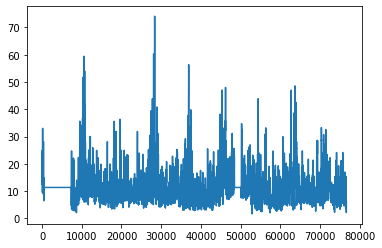

In [11]:


data,_ = load_data()

# plot
plt.plot(data)
plt.show()

# 'debug' cell to check dimension of things being passed around

In [ ]:
data, n_test = load_data()
maxEpochs =100
Repetitions=1
#model = MLP_Model(lookAhead= lookAhead, windowlength=windowSize, n_nodes = hidden_nodes,lossfcn=mylossfcn)
model = LSTM_Model(lookAhead= lookAhead, windowlength=windowSize, n_nodes = hidden_nodes, n_diff = 0,lossfcn=mylossfcn)
scores = repeat_evaluate(data, model, n_test,n_repeats=Repetitions)
#scorearray = np.array(scores)
#print (scorearray[:,0], scorearray[:,1])

(76655, 1)
setting n_test = 7665
Epoch 1/100
68943/68943 [==============================] - 15s 223us/step - loss: 29.0759
Epoch 2/100
68943/68943 [==============================] - 15s 221us/step - loss: 25.9671
Epoch 3/100
68943/68943 [==============================] - 15s 221us/step - loss: 25.3745
Epoch 4/100
68943/68943 [==============================] - 15s 223us/step - loss: 24.8845
Epoch 5/100
68943/68943 [==============================] - 15s 224us/step - loss: 24.6919
Epoch 6/100
68943/68943 [==============================] - 15s 222us/step - loss: 24.5877
Epoch 7/100
68943/68943 [==============================] - 15s 224us/step - loss: 24.4777
Epoch 8/100
68943/68943 [==============================] - 15s 221us/step - loss: 24.3108
Epoch 9/100
68943/68943 [==============================] - 15s 223us/step - loss: 24.3053
Epoch 10/100
68943/68943 [==============================] - 15s 224us/step - loss: 24.1830
Epoch 11/100
68943/68943 [==============================] - 15s 22

# Run each different model

In [ ]:
def Run_Models(useLogs=False, useStandard=False, epochs=2,repeats=2):
    global datapartname, useLogTransform, useStandardisation
    useLogTransform = useLogs
    useStandardisation = useStandard
    print(useLogs,useStandard)
    datapartname = '-raw'
    if (useLogTransform==True):
        datapartname = '-log'    
    if (useStandardisation == True):
        datapartname = datapartname + '-std'
    print("=======> running: ",datapartname)
    data, n_test = load_data()

    mseresults = DataFrame()
    maperesults = DataFrame()
    colnames = []

    model_list = []
    model_list.append(  persistent_Model(lookAhead= lookAhead, windowlength=windowSize))
    model_list.append(         MLP_Model(lookAhead= lookAhead, windowlength=windowSize, n_nodes = hidden_nodes,lossfcn=mylossfcn)   )
    model_list.append(         CNN_Model(lookAhead= lookAhead, windowlength=windowSize, n_filters = hidden_nodes, kernelsize=3,lossfcn=mylossfcn) )
    model_list.append(        LSTM_Model(lookAhead= lookAhead, windowlength=windowSize, n_nodes = hidden_nodes, n_diff = 0,lossfcn=mylossfcn)  )
    model_list.append(Stacked_LSTM_Model(lookAhead= lookAhead, windowlength=windowSize, n_nodes = hidden_nodes,lstmlayers = 2,n_diff = 0,lossfcn=mylossfcn))
    model_list.append(    CNN_LSTM_Model(lookAhead= lookAhead, windowlength=windowSize, n_seq=1,n_filters = hidden_nodes,kernelsize=3,lstmnodes=hidden_nodes,dense_nodes=hidden_nodes,lossfcn=mylossfcn))
    model_list.append(    ConvLSTM_Model(lookAhead= lookAhead, windowlength=windowSize, n_seq=1,n_filters = hidden_nodes,kernelsize=3,dense_nodes=hidden_nodes,lossfcn=mylossfcn))

    for model in model_list:
        print ("running ", model.name)
        scores = repeat_evaluate(data, model, n_test,n_repeats=Repetitions)
        scorearray = np.array(scores)
        mseresults[model.name]= Series(scorearray[:,0])
        maperesults[model.name] = Series(scorearray[:,1])
        colnames.append(model.name)

    outfilename = 'results/aggregated_Univariate_Results_mse_' + str(lookAhead) +'hr_'+ datapartname +'data.csv'
    mseresults.to_csv(outfilename)
    outfilename = 'results/aggregated_Univariate_Results_mape_' + str(lookAhead) +'hr_'+ datapartname +'data.csv'
    maperesults.to_csv(outfilename)

    mseplot = mseresults.boxplot(column=colnames)
    title = 'Boxplot of mse_results from 10 runs with ' +datapartname + ' univariate data'
    plt.title(title)
    plt.ylabel('RMSE in original scale')
    filename = 'results/'+title+'.jpg'
    plt.savefig(filename)
     
    mapeplot = maperesults.boxplot(column=colnames)
    title = 'Boxplot of mape_results from 10 runs with ' +datapartname + ' univariate data'
    plt.title(title)
    plt.ylabel('MAPE in original scale')
    filename = 'results/'+title+'.jpg'
    plt.savefig(filename)

In [ ]:
for mylog in (True,False):
    for myscaled in (True, False):
        Run_Models(useLogs=mylog, useStandard=myscaled, epochs=1,repeats=2)

In [ ]:
def SaveData(useLogs=False, useStandard=False, epochs=2,repeats=2):
    global datapartname, useLogTransform, useStandardisation
    useLogTransform = useLogs
    useStandardisation = useStandard
    print(useLogs,useStandard)
    datapartname = '-raw'
    if (useLogTransform==True):
        datapartname = '-log'    
    if (useStandardisation == True):
        datapartname = datapartname + '-std'
    print("=======> running: ",datapartname)
    data, n_test = load_data()
    train,test = train_test_split(data,n_test)
    #save train and test to file
    outname = 'train'  +datapartname +'.csv'
    np.savetxt(outname,train,delimiter=',')
    outname = 'test'  +datapartname +'.csv'
    np.savetxt(outname,test,delimiter=',')
        
for useLogs in (True,False):
    for useStandard in (True,False):
        SaveData(useLogs,useStandard)

In [ ]:
#data, n_test = load_data()
#scores = repeat_evaluate(data, MLP_Model(lookAhead= lookAhead, windowlength=windowSize, n_nodes = hidden_nodes) , n_test,n_repeats=Repetitions)